# Introduction

Speech Emotion Recognition (SER) is a burgeoning field within artificial intelligence that aims to automatically identify and categorize the emotions expressed in spoken language. It delves beyond the literal meaning of words to analyze subtle vocal cues like pitch, tone, rhythm, and prosody to infer the speaker's emotional state.


### About Dataset

Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

Check out our Kaggle Song emotion dataset.

Files

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

In [1]:
! pip install ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


In [2]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=7606c8be4c535c2675d9986fc898fdda09707a3f3857cd3310e551bdad71c139
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [3]:
import os
import sys

import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Paths for data.
# Ravdess = '/content/drive/MyDrive/RAVDNESS/'
Ravdess = 'https://github.com/samyogkc/Data-Science/tree/main/RAVDNESS'
Crema = '/content/drive/MyDrive/CREMA-D/'

In [45]:
import pandas as pd

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


FileNotFoundError: ignored

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/CREMA-D/1079_TIE_HAP_XX...
1    happy  /content/drive/MyDrive/CREMA-D/1079_TSI_HAP_XX...
2     fear  /content/drive/MyDrive/CREMA-D/1080_DFA_FEA_XX...
3  neutral  /content/drive/MyDrive/CREMA-D/1079_WSI_NEU_XX...
4    angry  /content/drive/MyDrive/CREMA-D/1079_TSI_ANG_XX...

In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/RAVDNESS/Actor_24/03-01...
1  neutral  /content/drive/MyDrive/RAVDNESS/Actor_24/03-01...
2    happy  /content/drive/MyDrive/RAVDNESS/Actor_24/03-01...
3     fear  /content/drive/MyDrive/RAVDNESS/Actor_24/03-01...
4     fear  /content/drive/MyDrive/RAVDNESS/Actor_24/03-01...

In [9]:
data_path['Emotions'].value_counts()

happy       192
fear        192
sad         192
disgust     192
calm        192
angry       192
surprise    192
neutral      96
Name: Emotions, dtype: int64

In [10]:
unwanted_emotions = ["disgust (1)", "surprised", "Sad", "Fear"]
data_path = data_path.drop(data_path[data_path["Emotions"].isin(unwanted_emotions)].index)


In [11]:
data_path['Emotions'].value_counts()

happy       192
fear        192
sad         192
disgust     192
calm        192
angry       192
surprise    192
neutral      96
Name: Emotions, dtype: int64

Text(0, 0.5, 'Count')

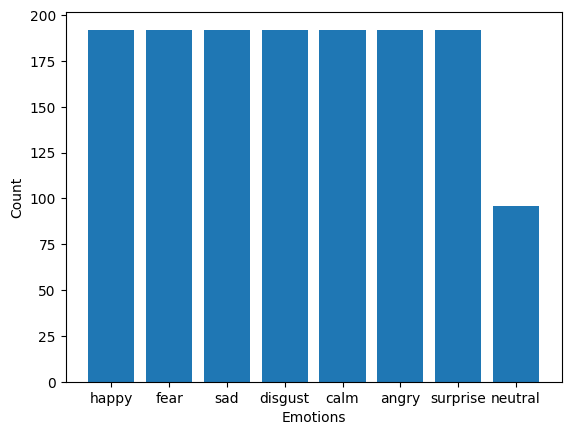

In [12]:
emotions_counts = data_path['Emotions'].value_counts()
plt.bar(emotions_counts.index, emotions_counts.values)
plt.xlabel("Emotions")
plt.ylabel("Count")

In [13]:
emotion_names=data_path['Emotions'].unique()

We can also plot waveplots and spectograms for audio signals

Waveplots - Waveplots let us know the loudness of the audio at a given time.
Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')

    plt.colorbar()

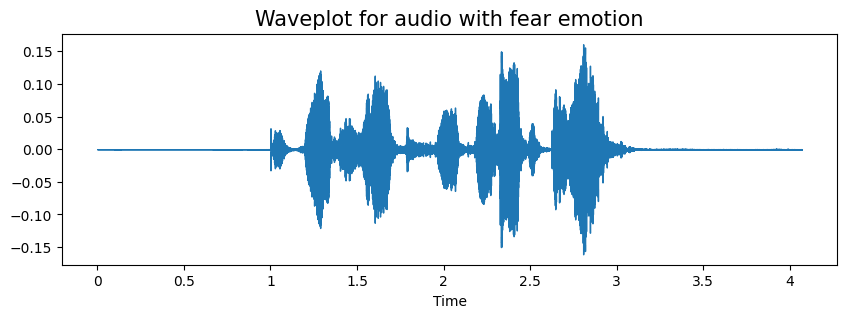

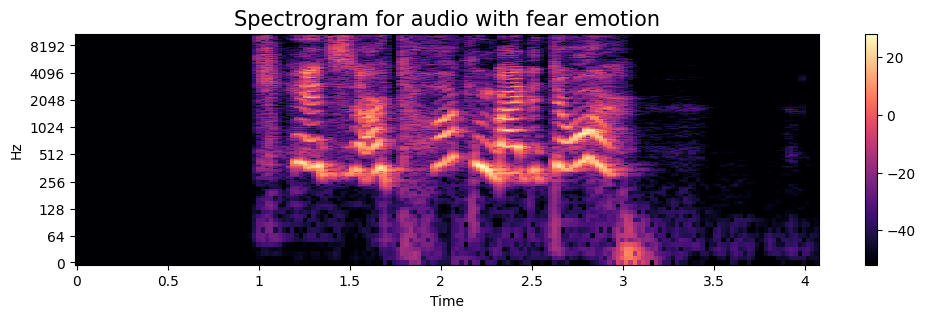

In [15]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

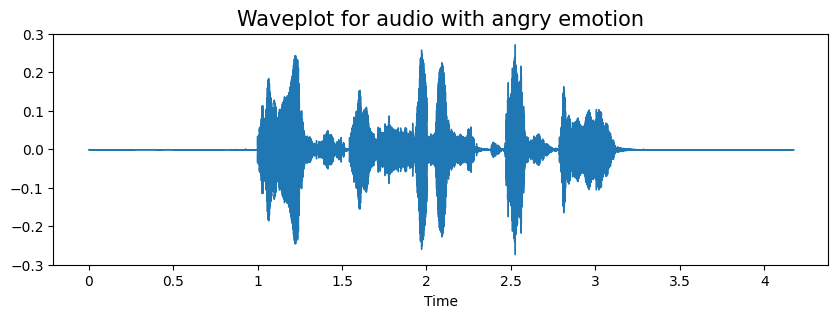

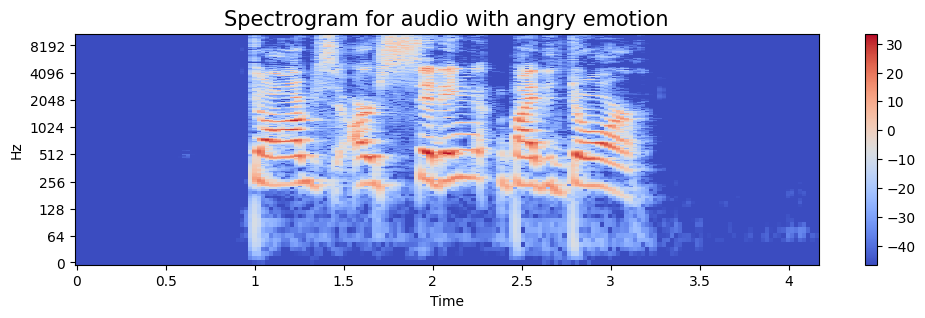

In [16]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

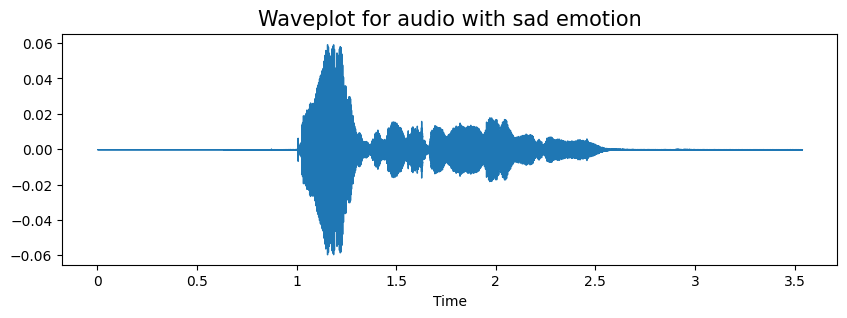

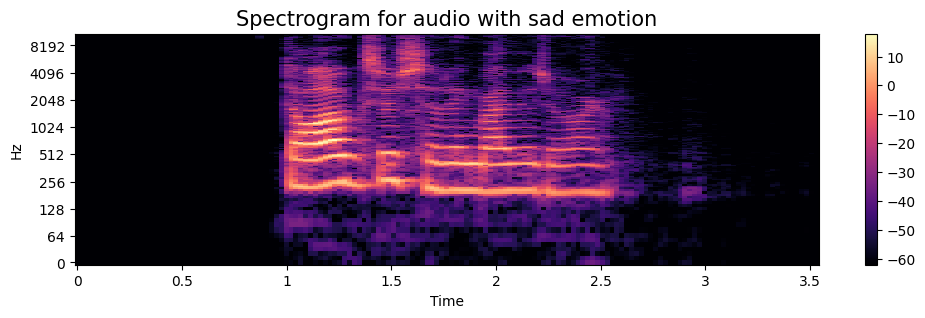

In [17]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

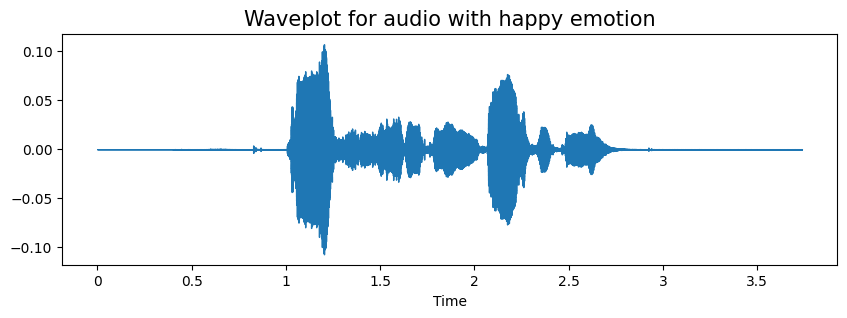

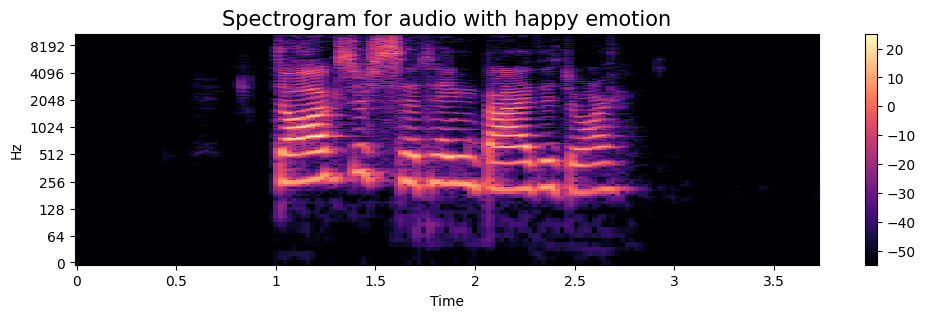

In [18]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.
In images data augmention can be performed by shifting the image, zooming, rotating ...
First, let's check which augmentation techniques works better for our dataset

In [19]:
data, sample_rate = librosa.load(path)

In [20]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitch(data):
    return librosa.effects.pitch_shift(data,sr=sample_rate,n_steps=2)

def stretching(data,rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

In [21]:
data,sr=librosa.load(path)

## 1.Original Audio

In [22]:
import IPython

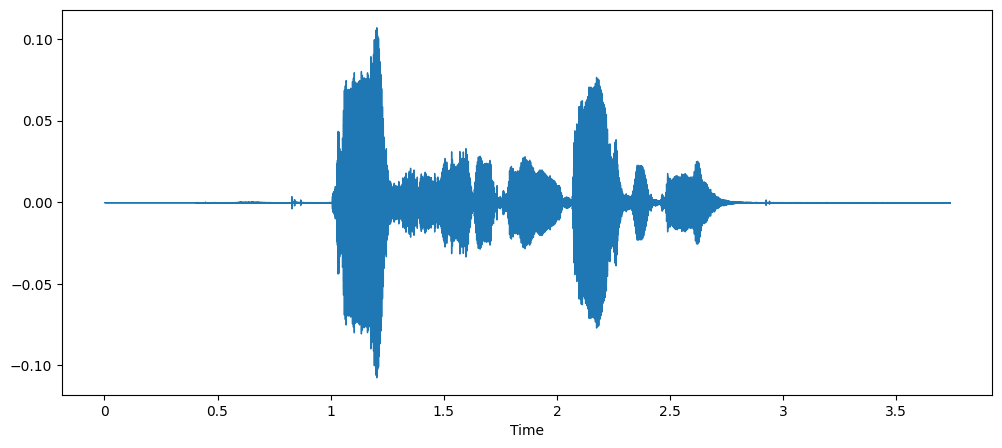

In [23]:
plt.figure(figsize=(12,5))
librosa.display.waveshow(data)
IPython.display.Audio(path)

## 2.Noise Injection

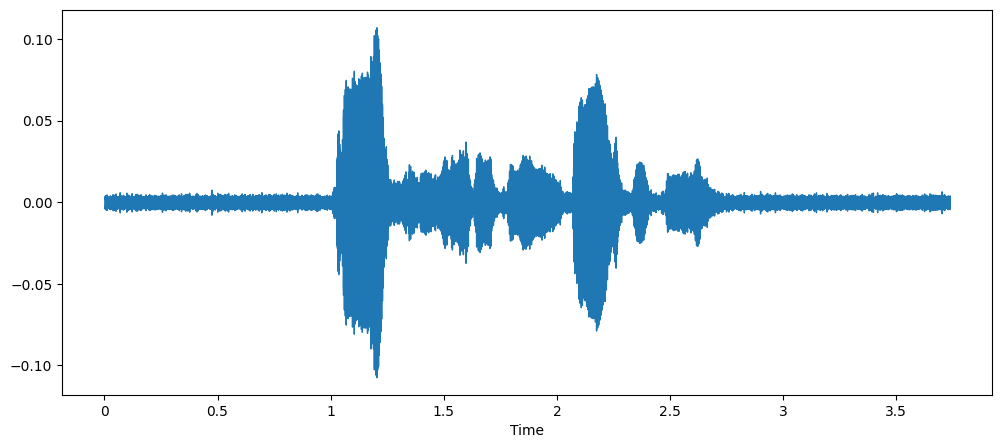

In [24]:
# x = add_noise(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(noised_audio)
IPython.display.Audio(noised_audio,rate=sr)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

## 3.Stretching

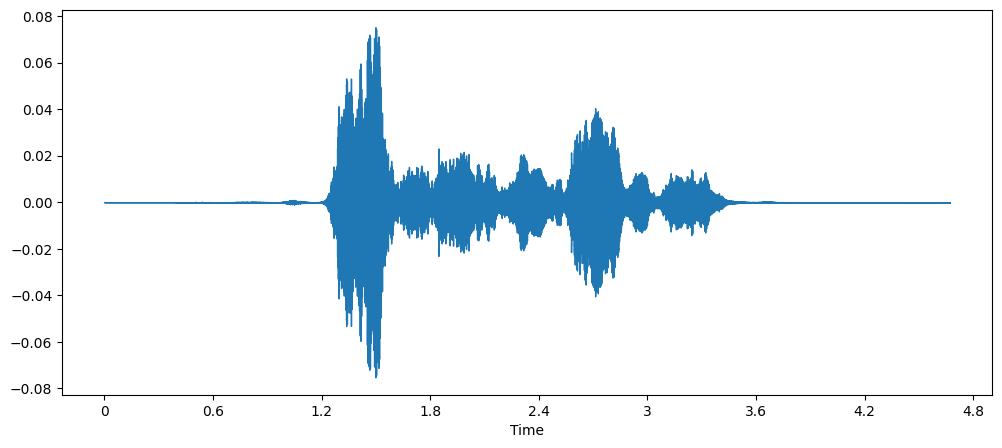

In [25]:
stretched_audio=stretching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(stretched_audio)
IPython.display.Audio(stretched_audio,rate=sr)

# Shifted Audio

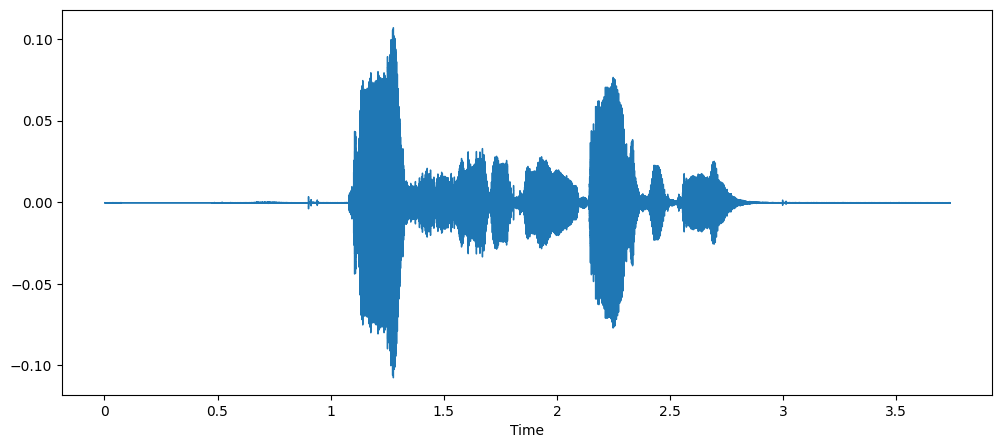

In [26]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(shifted_audio)
IPython.display.Audio(shifted_audio,rate=sr)

## Pitch

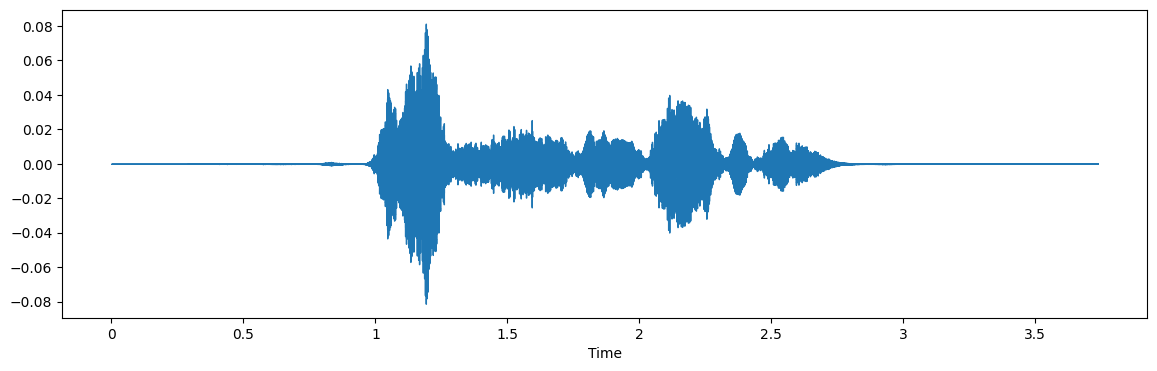

In [27]:
x = pitch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


# Feature Extraction

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.

Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
Energy : The sum of squares of the signal values, normalized by the respective frame length.
Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
Spectral Centroid : The center of gravity of the spectrum.
Spectral Spread : The second central moment of the spectrum.
Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
Chroma Deviation : The standard deviation of the 12 chroma coefficients.
In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [28]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)
def mfcc1(data, sr, frame_length=2048, hop_length=512):
    mfcc1 = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=hop_length)
    return mfcc1.T # Transpose the result to have time along the rows


def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result



def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data,sr=sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = add_noise(data)
    res2 = extract_features(noise_data,sr=sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data  pitching
    new_data = pitch(data)
    res3 = extract_features(new_data,sr=sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

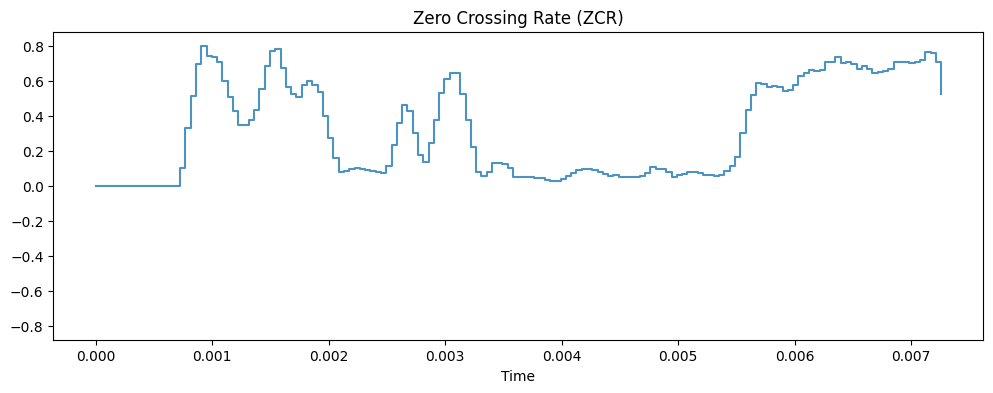

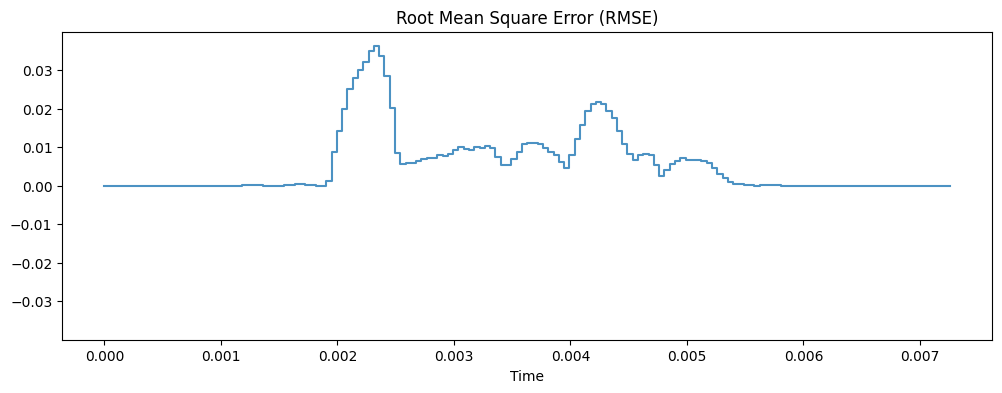

MFCC shape: (161, 13)


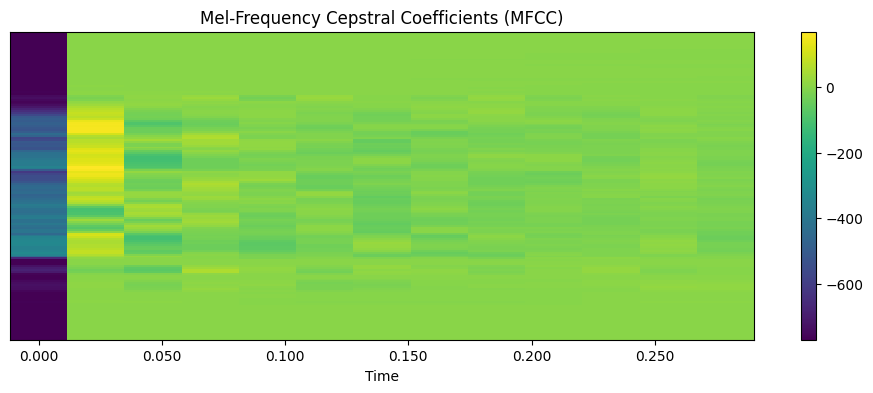

In [29]:
import librosa.display
import matplotlib.pyplot as plt

# Zero Crossing Rate (ZCR)
zcr_result = zcr(data, frame_length=2048, hop_length=512)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(zcr_result, sr=sample_rate, alpha=0.8)
plt.title('Zero Crossing Rate (ZCR)')
plt.show()

# Root Mean Square Error (RMSE)
rmse_result = rmse(data, frame_length=2048, hop_length=512)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(rmse_result, sr=sample_rate, alpha=0.8)
plt.title('Root Mean Square Error (RMSE)')
plt.show()

# Mel-Frequency Cepstral Coefficients (MFCC)
mfcc_result = mfcc1(data,sr=sample_rate, frame_length=2048, hop_length=512)
print("MFCC shape:", mfcc_result.shape)
# Use time as the x-axis
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc_result, sr=sample_rate, x_axis='time', hop_length=512, cmap='viridis')
plt.colorbar()
plt.title('Mel-Frequency Cepstral Coefficients (MFCC)')
plt.show()

### Feature extraction

In [30]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [31]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [32]:
Features = pd.DataFrame(X)
Features['Emotions'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.318848  0.541992  0.743652  0.805176  0.759277  0.718262  0.708496   
1  0.247070  0.375000  0.505859  0.504883  0.500000  0.502930  0.501465   
2  0.244629  0.343750  0.420898  0.367676  0.309570  0.266602  0.261230   
3  0.000000  0.000000  0.000000  0.000000  0.158691  0.374512  0.575684   
4  0.247070  0.364746  0.491699  0.500977  0.496582  0.500000  0.494629   

          7         8         9  ...      1611      1612      1613      1614  \
0  0.726562  0.773438  0.674316  ...  5.757586  4.247482  3.010612  1.660511   
1  0.502441  0.503418  0.488770  ...  0.104094  0.121301  1.679679 -0.261222   
2  0.250488  0.262207  0.296875  ...  3.322040  2.310954  1.333166 -0.252900   
3  0.701660  0.651367  0.435547  ...  5.271970  3.833244  2.593021  1.339437   
4  0.496582  0.500977  0.517578  ...  4.186521  4.206372  0.083184  5.150127   

       1615      1616      1617      1618      1619  Emotions  
0 -0.039230 -1.939274 -3.554991 -4.363783 -4.141699     happy  
1  2.262515  5.332137 -1.530977 -2.005680  1.718802     happy  
2 -2.308970 -4.006703 -4.548167 -3.836291 -2.513532     happy  
3 -0.045346 -1.482778 -2.742157 -3.569102 -3.815752   neutral  
4  1.901226  1.919250  2.613331  3.338879 -0.133752   neutral  

[5 rows x 1621 columns]

In [33]:
X_feat=Features.drop(labels='Emotions',axis=1)
y_feat = Features['Emotions'].values

In [34]:
Features.Emotions.value_counts()

happy       576
fear        576
sad         576
disgust     576
calm        576
angry       576
surprise    576
neutral     288
Name: Emotions, dtype: int64

In [35]:
Features = Features.dropna()

In [36]:
X_feat.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
1615    45
1616    45
1617    45
1618    45
1619    45
Length: 1620, dtype: int64

In [37]:
X_feat.shape

(4320, 1620)

In [38]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_feat = encoder.fit_transform(np.array(y_feat).reshape(-1,1)).toarray()

In [39]:
y_feat.shape

(4320, 8)

# Modelling



## Training and Spliting

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_feat,y_feat,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3456, 1620), (864, 1620), (3456, 8), (864, 8))

In [41]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_train_scaled.shape,X_test_scaled.shape,y_train.shape,y_test.shape

((3456, 1620), (864, 1620), (3456, 8), (864, 8))

In [42]:
from sklearn.svm import SVC

In [43]:
# Train SVM model
model1 = SVC(kernel="linear")
# Convert y_train to a 1D array of class labels
model1.fit(X_train_scaled, y_train[:,1])

# Evaluate model performance
y_pred = model1.predict(X_test_scaled)
accuracy = np.mean(y_pred == y_test[:,1])
print(f"Accuracy: {accuracy:.4f}")

ValueError: ignored

The accuracy of 93% was achieved.

## Model 2
MLP Classifier
The Multi-Layer Perceptron (MLP) is a type of artificial neural network commonly used for classification tasks. It is inspired by the biological structure of the human brain, with interconnected layers of "neurons" that process information and learn to distinguish patterns.

__Advantages:__

Universal approximator: MLPs can learn complex relationships within data, making them versatile for diverse tasks beyond classification like regression and forecasting.

Adaptive learning: They continuously improve by adjusting their internal weights based on new data.

Flexible architecture: The number of layers and neurons can be adjusted to fit the complexity of the problem.

__Disadvantages:__

Black box nature: It can be difficult to interpret how the network arrives at its decisions, making them less transparent than some other algorithms.

Overfitting: Training on limited data can lead to the network memorizing specific patterns instead of generalizing to unseen examples.

Tuning hyperparameters: Choosing the right number of layers, neurons, and learning rate can be challenging.


In [ ]:
model2 = MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
model2.fit(X_train_scaled, y_train)

In [ ]:
#Predict for the test set
y_pred_2 = model2.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score

#Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_2[:,1]
df['Actual Labels'] = y_test[:,1]

df.head(10)

__Lets use different technique for the feature extraction and use LSTM and CNN.__

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(data_path['Path'][0])

In [ ]:
X_mfcc = data_path['Path'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

In [ ]:
## input split
X = np.expand_dims(X, -1)
X.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(data_path[['Emotions']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history = model.fit(X, y, validation_split=0.4, epochs=100, batch_size=64)

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model2 = Sequential()

model2.add(Conv1D(128, 5,padding='same',input_shape=(1620,1)))        #1
model2.add(Activation('relu'))
model2.add(Dropout(0.1))
model2.add(MaxPooling1D(pool_size=(8)))



model2.add(Conv1D(128, 5,padding='same',))                           #2
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Flatten())
model2.add(Dense(8))                                                 #3
model2.add(Activation('softmax'))
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.00001, rho=0.9, epsilon=None, decay=0.0)



In [ ]:

model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [ ]:
cnnhistory=model2.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test))

In [ ]:
import plotly.express as px
fig=px.line(cnnhistory.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from tensorflow.keras import layers

In [ ]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
model=tf.keras.Sequential([
    layers.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    layers.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    layers.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    layers.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    layers.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=3,strides=2,padding='same'),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
history=saved_model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test), batch_size=32)

In [ ]:
    # After your model training finishes
model.save('my_model.h5')

In [ ]:
saved_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
import plotly.express as px
fig=px.line(history.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
epochs = list(range(41))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()